In [15]:
pip show scikit-learn imbalanced-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: autoai_libs, autoai_ts_libs, imbalanced-learn, lale, scikeras, skl2onnx, sklearn-compat, snapml
---
Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: /opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip uninstall -y scikit-learn imbalanced-learn


Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0


  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from imblearn.over_sampling import SMOTE
print("✅ SMOTE imported successfully!")

✅ SMOTE imported successfully!


✅ Dataset loaded successfully from Google Drive!

📋 Columns in the dataset:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']
✅ 'FailureType' column already exists.

✅ Data cleaning and target variable setup complete.
✅ Data split into training and testing sets.
🔁 Applying SMOTE to balance classes...

🔍 Class distribution BEFORE SMOTE:
 FailureType
No Failure                  7722
Heat Dissipation Failure      90
Power Failure                 76
Overstrain Failure            62
Tool Wear Failure             36
Random Failures               14
Name: count, dtype: int64

✅ Class distribution AFTER SMOTE:
 FailureType
No Failure                  7722
Tool Wear Failure           7722
Random Failures             7722
Power Failure               7722
Heat Dissipation Failure    7722
Overstrain Failure          7722
Name: count, dtype: int64
🔁 Training RandomForestClassifier wit

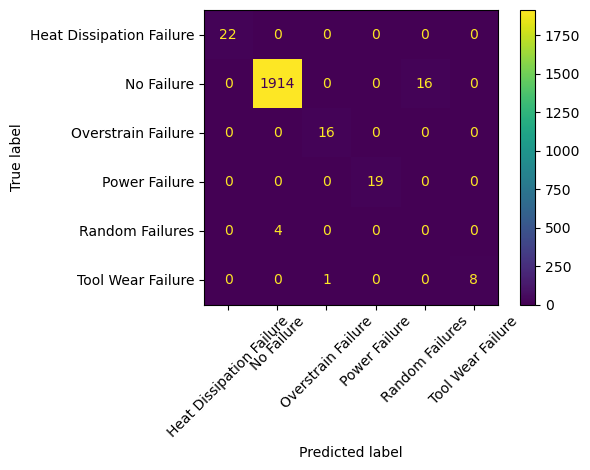

In [2]:
import pandas as pd
import io
import ibm_boto3
from ibm_botocore.client import Config
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Phase 1: Data Understanding and Loading ---

# --- Updated credentials for Cloud Object Storage ---
COS_API_KEY_ID = "UpxgLiKMIoToqUv3JSUcJnmGj0S_vwtcdU9xl0Q09TRX"
COS_SERVICE_CRN = "crn:v1:bluemix:public:cloud-object-storage:global:a/304e2aa3d07e488bae9e07bd28e6d80e:147fa9fc-16b0-47bf-bab0-475bb4519a8c::"
COS_ENDPOINT = "https://s3.au-syd.cloud-object-storage.appdomain.cloud"  # Ensure this matches the bucket region
COS_BUCKET = "predictivemaintenanceproject-donotdelete-pr-8dpsogs2zdvvbh"
COS_FILE_NAME = "ai4i2020.csv"

# Create the Cloud Object Storage client
try:
    cos_resource = ibm_boto3.resource("s3",
        ibm_api_key_id=COS_API_KEY_ID,
        ibm_service_instance_id=COS_SERVICE_CRN,
        config=Config(signature_version="oauth"),
        endpoint_url=COS_ENDPOINT
    )
    my_file_object = cos_resource.Object(COS_BUCKET, COS_FILE_NAME).get()
    df = pd.read_csv(io.BytesIO(my_file_object['Body'].read()))
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    df = None

# --- Phase 2: Data Cleaning and Feature Engineering ---

if df is not None:
    df_clean = df.copy()
    df_clean.columns = df_clean.columns.str.replace('[^a-zA-Z0-9_]', '', regex=True)
    df_clean.rename(columns={
        'AirtemperatureK': 'AirTemperature',
        'ProcesstemperatureK': 'ProcessTemperature',
        'Rotationalspeedrpm': 'RotationalSpeed',
        'TorqueNm': 'Torque',
        'Toolwearmin': 'ToolWear',
        'Machinefailure': 'MachineFailure'
    }, inplace=True)
    failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    df_clean['FailureType'] = 'NoFailure'
    for col in failure_cols:
        df_clean.loc[df_clean[col] == 1, 'FailureType'] = col
    df_clean.drop(columns=['UDI', 'ProductID', 'MachineFailure'] + failure_cols, inplace=True)
    
    print("\nData cleaning and target variable creation complete.")

    # --- Phase 3: Model Training and Evaluation ---

    # Separate features (X) and the target variable (y)
    X = df_clean.drop('FailureType', axis=1)
    y = df_clean['FailureType']

    # Handle categorical features using one-hot encoding
    X = pd.get_dummies(X, columns=['Type'], drop_first=True)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("\nData split into training and testing sets.")

    # Train the Machine Learning Model using 'class_weight'
    print("Training a RandomForestClassifier model with balanced class weights...")
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    print("Model training complete.")

    # Evaluate the Model on the original test set
    y_pred = model.predict(X_test)
    print("\n--- Model Evaluation: Classification Report ---")
    print(classification_report(y_test, y_pred))

    # Get feature importances
    print("\n--- Feature Importances ---")
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances)

else:
    print("Skipping subsequent phases due to data loading failure.")